In [1]:
# Testing imgage in python
# Let's generate a set of data of simple shapes and then create a deep network to classify them
# As per YOLO, define a grid of size S * NUM_SHAPES over the image and place a 1 where the object
# center is.  Then we will manipulate our deep network to output the same sized tensor and run a 
# simple squared error calculation for loss.  In this way we can detect the type of object, but also
# it's location in the image.
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math

import pdb

from enum import Enum

class Shape(Enum):
    CIRCLE = 0
    RECTANGLE = 1
    TRIANGLE = 2

# Grid size
S=10

# Image size
h=128
w=128

# Grid width and height
s_h = h / S
s_w = w / S

# Number of each type of object to create
NUM_SAMP = 5000

# Image data to feed in as input to the network
x_data=np.empty([NUM_SAMP*3, h, w, 3])

# Tensor output to compare to the network output.  This will be our
# new y_train and y_test
y_data=np.zeros([NUM_SAMP*3, S, S, 3])

# TODO: Abstract this away to a class structure - a lot of replication here
for i in range(NUM_SAMP):
    # Circles
    img = np.zeros((h,w,3), np.uint8)

    cc = (random.randint(0, h-1), random.randint(0, w-1))
    
    #pdb.set_trace()
    
    cv2.circle(img, cc, random.randint(10, 50), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), -1)
    x_data[i,:,:,:] = img/255
    
    g_point = (math.floor(cc[0] / s_w), math.floor(cc[1] / s_h))
    y_data[i, g_point[1], g_point[0], 0] = 1
    
    # Rectangles
    img = np.zeros((h,w,3), np.uint8)
    
    tl = (random.randint(0, h-1), random.randint(0, w-1))
    br = (random.randint(0, h-1), random.randint(0, w-1))
    
    # Calculate center
    cc = ((br[0]+tl[0])/2, (br[1]+tl[1])/2)
    
    cv2.rectangle(img, tl, br, 
                 (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), -1)
    x_data[i+NUM_SAMP,:,:,:] = img/255
    
    g_point = (math.floor(cc[0] / s_w), math.floor(cc[1] / s_h))  
    y_data[i+NUM_SAMP, g_point[1], g_point[0], 1] = 1
    
    # Triangles
    img = np.zeros((h,w,3), np.uint8)
    
    p1 = [random.randint(0, h-1), random.randint(0, w-1)]
    p2 = [random.randint(0, h-1), random.randint(0, w-1)]
    p3 = [random.randint(0, h-1), random.randint(0, w-1)]
    
    # Calculate center
    cc = ((p1[0]+p2[0]+p3[0])/3, (p1[1]+p2[1]+p3[1])/3)
    pts = np.array([p1, p2, p3])
    
    cv2.fillPoly(img, [pts], (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))
    x_data[i+NUM_SAMP*2,:,:,:] = img/255
    
    g_point = (math.floor(cc[0] / s_w), math.floor(cc[1] / s_h))
    y_data[i+NUM_SAMP*2, g_point[1], g_point[0], 2] = 1

#y_data=np.concatenate((np.ones((1, NUM_SAMP))*0, np.ones((1, NUM_SAMP))*1, np.ones((1, NUM_SAMP))*2), axis=None)

#y_data
#nplt.imshow(x_data[290, :, :, :])

In [2]:
# Function to plot the grid and center point of our made up images
import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=(h / S))

def plot_img(x_data, y_data, i):
    img=x_data[i, :, :, :]
    
    y=y_data[i, :, :, :]

    obj_ind = np.where(y==1)

    obj_type = obj_ind[2][0]
  
    obj_center =(math.floor(obj_ind[1][0] * s_h + s_h/2), math.floor(obj_ind[0][0] * s_w + s_w/2))

    print([str(Shape(obj_type)) + ' located at ' + str(obj_center)])    
    
    print(obj_ind[0][0] * h/S)   
    
    
    fig=plt.figure(figsize=(10, 10))
    ax=fig.add_subplot(111)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-', color='g')
    
    cv2.circle(img, obj_center, 2, (255, 0, 0), -1)
    
    ax.imshow(img)
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['Shape.TRIANGLE located at (32, 70)']
64.0


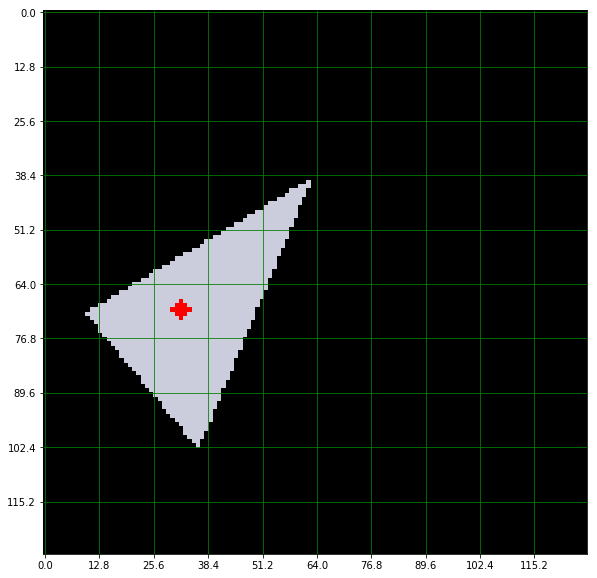

In [3]:
plot_img(x_data, y_data, 2500)

In [12]:
# Now we have some made up data in x_data, y_data of basic shapes.  Split into test and validation sets and train a simple network
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

In [10]:
Y_train.shape

(2010, 10, 10, 3)

In [16]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import tensorflow as tf
#from keras.utils import to_categorical

from keras.applications.vgg16 import VGG16

batch_size = 64
num_classes = 3
epochs = 20

# input image dimensions
img_rows, img_cols = w, h

input_shape = (img_rows, img_cols, 3)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(Y_train, num_classes)
#y_test = keras.utils.to_categorical(Y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dense(4096, activation='relu'))
# Unsure, but I believe this is the best way to get a tensor at the end with no activation.  Just a linear connection to reorganize the last 
# dense network into a tensor of the proper size
model.add(Dense(S*S*3))
model.add(Reshape((S, S, 3)))
#model.add(Dropout(0.5))
#model.add(Dense(num_classes, activation='softmax'))    
 
# let's define the loss function by hand
def get_cat_crossentropy_loss():
    def weighted_loss(y_true, y_pred):
        # scale preds so that the class probas of each sample sum to 1
        # Don notes: Haven't figured out why this is required.  y_pred is the output of softmax,
        # and so should already sum to 1???
        y_pred_sum = K.print_tensor(tf.reduce_sum(y_pred, -1, True), message="y_pred is: ")
        y_pred /= y_pred_sum
        # manual computation of crossentropy
        # Don notes: Looks like any math has to be as a tensor in the same type
        _epsilon = tf.convert_to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
        # Don notes: We clip the values of y_pred to be away from the asymtopes of the log
        # function.  If we didn't, we will get inf or NaN values.
        y_pred = tf.clip_by_value(y_pred, _epsilon, 1. - _epsilon)
        return - tf.reduce_sum(y_true * tf.log(y_pred), -1)
    return weighted_loss

def get_yolo_simple():
    def yolo_simple(y_true, y_pred):
        # Okay so just a simple squared error between output of network and the S*S*NUM_SHAPE y_true
        loss = tf.reduce_sum(K.pow(y_true-y_pred, 2))
        loss = K.print_tensor(loss, message="loss is: ")
        return loss
    return yolo_simple
    
print(model.summary())

model.compile(loss=get_yolo_simple(),
              optimizer=keras.optimizers.adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (2010, 128, 128, 3)
2010 train samples
990 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 58, 58, 64)        36928     
_________________________________________________________________
max_p

In [6]:
import sys

x=np.array(([0.1, 0.9, 0.4], [0.9, 0.2, 0.3]))

y=np.array(([0, 1, 0], [1, 0, 0]))

print(np.sum(-np.log(x[y.astype('bool')])))

print(np.sum(-np.log(x+sys.float_info.epsilon)*y))

0.21072103131565256
0.21072103131565206


In [24]:
y_pred=model.predict_classes(x_test)
y_prob=model.predict_proba(x_test)

Shape.RECTANGLE
100.0%


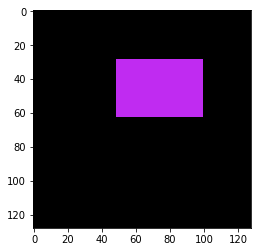

In [36]:
img_num = random.randint(0, x_test.shape[0])

plt.imshow(x_test[img_num, :, :, :])

print(Shape(y_pred[img_num]))
print((str(y_prob[img_num][y_pred[img_num]]*100) + '%'))